### Analytics Cup 2024 - Max Script

#### **Set up**

In [51]:
# Installing the Packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from IPython.display import display, HTML


In [52]:
# Setting the Seed (pandas, statsmodels, matplotlib and y_data_profiling rely on numpy's random generator, and thus, we need to set the seed in numpy
seed = 2024
np.random.seed(seed)

In [53]:
# Importing the data 

# Importing the data 
diet_df = pd.read_csv("diet.csv")
recipes_df = pd.read_csv("recipes.csv")
requests_df = pd.read_csv("requests.csv")
reviews_df = pd.read_csv("reviews.csv")

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.


#### **Data Understanding and Cleaning**

In [54]:
# General Notes: 
# One diet per AuthorId
# One recipe per RecipeId 
# Several requests per author (But only one request per author per recipe) 
# Several reviews per author (But only one review per author per recipe) 

# 1) Merged diets and reviews -> Dataset with reviews and diet information 
# 2) Merged (diets & reviews) with requests on AuthorId and RecipeId


#### Diet Understanding ✅

In [55]:
# Get overview of the diet dataset.
print(diet_df.head())
print()
print(diet_df.info())
print()
print(diet_df.isnull().sum()) # --> 1 missing value in the "Diet" column
print()

# Row with the missing value: 
print(diet_df[diet_df.isnull().any(axis=1)])
# --> AuthorId: 5, Diet: NaN


    AuthorId        Diet  Age
0  10000120E  Vegetarian   46
1   1000014D       Vegan   18
2   1000015A  Vegetarian   58
3   1000016E  Vegetarian   32
4   1000027E       Vegan   61

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271907 entries, 0 to 271906
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   AuthorId  271907 non-null  object
 1   Diet      271906 non-null  object
 2   Age       271907 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.2+ MB
None

AuthorId    0
Diet        1
Age         0
dtype: int64

       AuthorId Diet  Age
242181  646062A  NaN   63


                 Age
count  271907.000000
mean       48.503727
std        17.898130
min        18.000000
25%        33.000000
50%        48.000000
75%        64.000000
max        79.000000


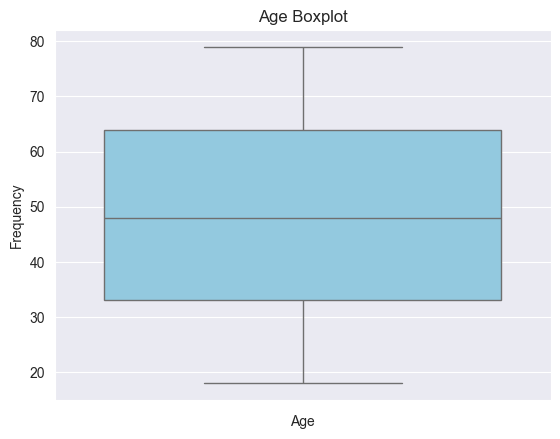

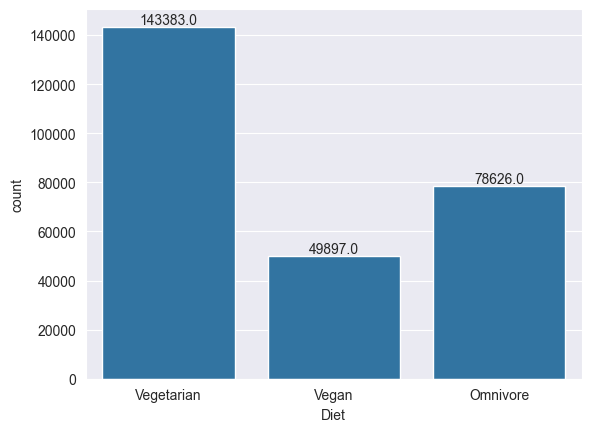

In [56]:
# Describing the diet dataset
print(diet_df.describe())



# Create the boxplot for the age column
sns.boxplot(y=diet_df["Age"], color="skyblue")  # Set the color
plt.title("Age Boxplot")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Create a barplot for the diet column
ax = sns.countplot(x='Diet', data=diet_df)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.show()


In [57]:
# Show how many unique Authors there are in the diet dataset
print(diet_df['AuthorId'].nunique()) # --> 271907 unique authors --> Every row is a unique author
print(diet_df['AuthorId'].duplicated().sum())

271907
0


In [58]:
# General Insights: 
# - 3 Attirubtes
# - In the diet column we have 1 row with a null value 


#### Diet Cleaning ✅

In [59]:
# Drop the row in the diet dataset with the missing value. 
diet_df = diet_df.dropna() # Potential implications: When merging we loose a row of data. 

# Make the "Diet" column of type category & dummy variable encode it.
diet_cleaned = pd.get_dummies(diet_df, columns=['Diet'], drop_first=True)

diet_cleaned



,AuthorId,Age,Diet_Vegan,Diet_Vegetarian
0,10000120E,46,False,True
1,1000014D,18,True,False
2,1000015A,58,False,True
3,1000016E,32,False,True
4,1000027E,61,True,False
...,...,...,...,...
271902,999917E,28,False,True
271903,999936C,22,False,False
271904,99993D,58,False,True
271905,99994A,18,False,True


#### Recipes Understanding 🚧

In [60]:
# General Recipe Overview
display(recipes_df.head())
print()
# print(recipes_df.info())
#print()
print(recipes_df.isnull().sum()) # --> No missing values in the ProteinContent column, 26713 missing values in the RecipeServings column, 50295 missing values in the RecipeYield column

,RecipeId,Name,CookTime,PrepTime,RecipeCategory,RecipeIngredientQuantities,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield
0,73440,Bow Ties With Broccoli Pesto,0,1800,Other,"c(""\""6\"""", ""\""2\"""", ""\""1 1/2\"""", ""\""1/4\"""", ""\...","c(""\""hazelnuts\"""", ""\""broccoli florets\"""", ""\""...",241.3,10.1,1.2,0.0,13.1,31.8,2.3,1.4,6.7,9.0,NaN
1,365718,Cashew-chutney Rice,3600,600,Other,"c(""\""1\"""", ""\""3/4\"""", ""\""6\"""", ""\""5\"""", ""\""2\""...","c(""\""celery\"""", ""\""onion\"""", ""\""butter\"""", ""\""...",370.8,17.5,7.2,22.9,553.3,44.3,1.6,2.2,9.4,8.0,NaN
2,141757,Copycat Taco Bell Nacho Fries BellGrande,3600,2700,Other,"c(""\""3\"""", ""\""1/2\"""", ""\""1\"""", ""\""1\"""", ""\""3\""...","c(""\""Copycat Taco Bell Seasoned Beef\"""", ""\""ye...",377.6,20.9,10.5,45.7,1501.8,36.6,3.8,6.1,12.9,8.0,NaN
3,280351,Slow Cooker Jalapeno Cheddar Cheese Soup,18000,1800,Other,"c(""\""2\"""", ""\""1\"""", ""\""2\"""", ""\""2\"""", ""\""1\"""",...","c(""\""unsalted butter\"""", ""\""yellow onion\"""", ""...",282.8,16.5,10.3,50.5,630.2,22.8,2.3,2.7,11.7,6.0,NaN
4,180505,Cool & Crisp Citrus Chiffon Pie,3600,1800,Other,"c(""\""1\"""", ""\""1/4\"""", ""\""1/2\"""", ""\""1/2\"""", ""\...","c(""\""unflavored gelatin\"""", ""\""water\"""", ""\""su...",257.5,8.6,2.4,110.7,160.9,39.8,0.4,30.2,6.3,6.0,NaN



RecipeId                          0
Name                              0
CookTime                          0
PrepTime                          0
RecipeCategory                    0
RecipeIngredientQuantities        0
RecipeIngredientParts             0
Calories                          0
FatContent                        0
SaturatedFatContent               0
CholesterolContent                0
SodiumContent                     0
CarbohydrateContent               0
FiberContent                      0
SugarContent                      0
ProteinContent                    0
RecipeServings                26713
RecipeYield                   50295
dtype: int64


Empty DataFrame
Columns: [RecipeId, Name, CookTime, PrepTime, RecipeCategory, RecipeIngredientQuantities, RecipeIngredientParts, Calories, FatContent, SaturatedFatContent, CholesterolContent, SodiumContent, CarbohydrateContent, FiberContent, SugarContent, ProteinContent, RecipeServings, RecipeYield]
Index: []
count    7.560400e+04
mean     5.490711e+03
std      1.043468e+05
min      0.000000e+00
25%      6.000000e+02
50%      1.200000e+03
75%      2.700000e+03
max      1.036800e+07
Name: CookTime, dtype: float64


<Axes: ylabel='CookTime'>

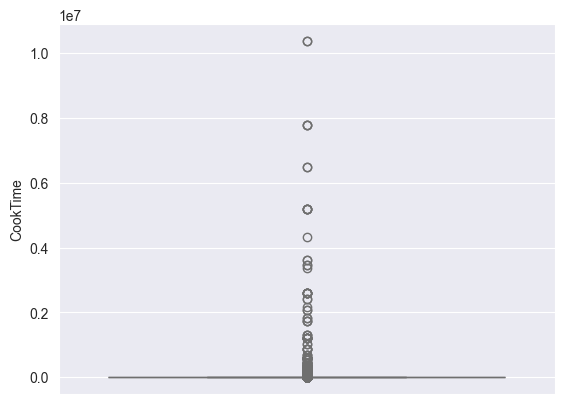

In [61]:
# Describing the Cook Time

# Missing values in the cooktime column
print(recipes_df[recipes_df['CookTime'].isnull()]) # --> 0 missing values in the CookTime column

# Describe the cooktime column
print(recipes_df['CookTime'].describe())

# Boxplot of Cooktime 
sns.boxplot(y=recipes_df["CookTime"], color="skyblue") # The values are very far apart


# Problems: 
# - Values incredibly far apart and don't make sense.
# - Probably in seconds? 

# What to do? 
# - Delete abnormalities 
# - Normalize it? 

Empty DataFrame
Columns: [RecipeId, Name, CookTime, PrepTime, RecipeCategory, RecipeIngredientQuantities, RecipeIngredientParts, Calories, FatContent, SaturatedFatContent, CholesterolContent, SodiumContent, CarbohydrateContent, FiberContent, SugarContent, ProteinContent, RecipeServings, RecipeYield]
Index: []
count    7.560400e+04
mean     3.158604e+03
std      8.656302e+04
min      0.000000e+00
25%      6.000000e+02
50%      9.000000e+02
75%      1.200000e+03
max      1.728000e+07
Name: PrepTime, dtype: float64


<Axes: ylabel='PrepTime'>

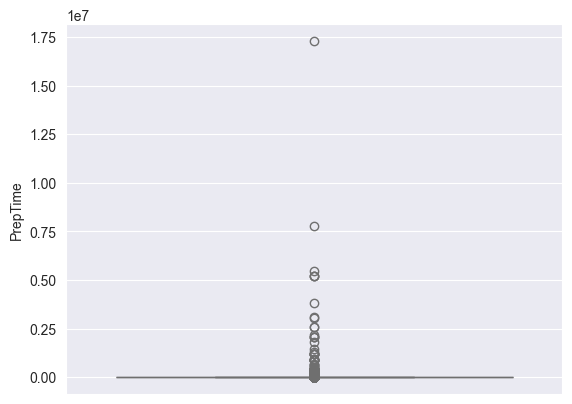

In [62]:
# Describing the Prep Time

# Missing values in the PrepTime column
print(recipes_df[recipes_df['PrepTime'].isnull()]) # --> 0 missing values in the PrepTime column

# Describe the PrepTime column
print(recipes_df['PrepTime'].describe())

# Boxplot of PrepTime
sns.boxplot(y=recipes_df["PrepTime"], color="skyblue") # Their are outliers. But most values around the bottom. 

# Problems: 
# - Values incredibly far apart and don't make sense.
# - Probably in seconds? 

# What to do? 
# - Delete outliers 
# - Normalize it? 

Empty DataFrame
Columns: [RecipeId, Name, CookTime, PrepTime, RecipeCategory, RecipeIngredientQuantities, RecipeIngredientParts, Calories, FatContent, SaturatedFatContent, CholesterolContent, SodiumContent, CarbohydrateContent, FiberContent, SugarContent, ProteinContent, RecipeServings, RecipeYield]
Index: []
RecipeCategory
Other            56347
Lunch             4887
One dish meal     4590
Bread             4246
Breakfast         3033
Beverages         2303
Soup               198
Name: count, dtype: int64
Axes(0.125,0.11;0.775x0.77)


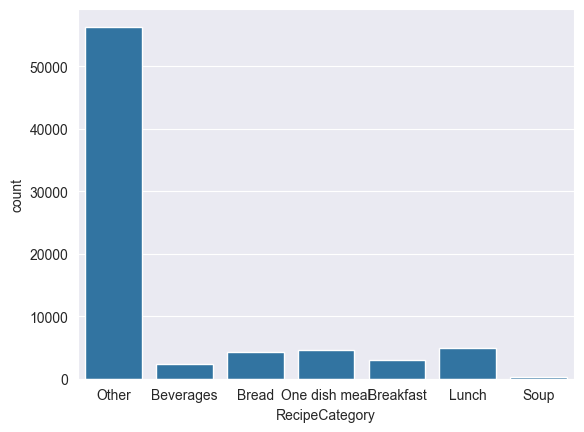

In [63]:
# Describing the Recipe Category

# Missing values in the RecipeCategory column
print(recipes_df[recipes_df['RecipeCategory'].isnull()]) # --> 0 missing values in the RecipeCategory column

# Number of values in the RecipeCategory column
print(recipes_df['RecipeCategory'].value_counts()) 
print(sns.countplot(x='RecipeCategory', data=recipes_df)); # 7 --> unique Recipe Categoreis (most of them in other)

# Problems: 
# - Recipes in the Category "Other" don't tell us much
# - We also don't have "Dinner". 

# What to do?
# - Somehow split up the other column 
# - Delete the other column
# - This column with the requests and see what categories could make sense. 


In [64]:
# Describing the "RecipeIngredientQuantities" column

# Missing values in the RecipeIngredientQuantities column
print(recipes_df[recipes_df['RecipeIngredientQuantities'].isnull()]) # --> 0 missing values in the RecipeIngredientQuantities column

# Number of values in the RecipeIngredientQuantities column
print(recipes_df['RecipeIngredientQuantities'].value_counts()) # --> 1 --> unique RecipeIngredientQuantities

# Insights: 
# - Not all values are unique (e.g. "\"1\"", "\"1\"", "\"1\"" exists 211 times)"


# Problems:

# What to do?






Empty DataFrame
Columns: [RecipeId, Name, CookTime, PrepTime, RecipeCategory, RecipeIngredientQuantities, RecipeIngredientParts, Calories, FatContent, SaturatedFatContent, CholesterolContent, SodiumContent, CarbohydrateContent, FiberContent, SugarContent, ProteinContent, RecipeServings, RecipeYield]
Index: []
RecipeIngredientQuantities
c("\"1\"", "\"1\"", "\"1\"")                                                                                                   211
c("\"1\"", "\"1\"")                                                                                                            170
c("\"1\"", "\"1\"", "\"1\"", "\"1\"")                                                                                          150
c("\"1\"", "\"1\"", "\"1\"", "\"1\"", "\"1\"")                                                                                 121
character(0)                                                                                                                   101
       

#### Recipe Cleaning 🚧

In [65]:
recipes_cleaned = recipes_df

In [66]:
# Handling (Dropping) Name Column

recipes_cleaned = recipes_df.drop(columns=['Name'])
recipes_cleaned

,RecipeId,CookTime,PrepTime,RecipeCategory,RecipeIngredientQuantities,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield
0,73440,0,1800,Other,"c(""\""6\"""", ""\""2\"""", ""\""1 1/2\"""", ""\""1/4\"""", ""\...","c(""\""hazelnuts\"""", ""\""broccoli florets\"""", ""\""...",241.3,10.1,1.2,0.0,13.1,31.8,2.3,1.4,6.7,9.0,NaN
1,365718,3600,600,Other,"c(""\""1\"""", ""\""3/4\"""", ""\""6\"""", ""\""5\"""", ""\""2\""...","c(""\""celery\"""", ""\""onion\"""", ""\""butter\"""", ""\""...",370.8,17.5,7.2,22.9,553.3,44.3,1.6,2.2,9.4,8.0,NaN
2,141757,3600,2700,Other,"c(""\""3\"""", ""\""1/2\"""", ""\""1\"""", ""\""1\"""", ""\""3\""...","c(""\""Copycat Taco Bell Seasoned Beef\"""", ""\""ye...",377.6,20.9,10.5,45.7,1501.8,36.6,3.8,6.1,12.9,8.0,NaN
3,280351,18000,1800,Other,"c(""\""2\"""", ""\""1\"""", ""\""2\"""", ""\""2\"""", ""\""1\"""",...","c(""\""unsalted butter\"""", ""\""yellow onion\"""", ""...",282.8,16.5,10.3,50.5,630.2,22.8,2.3,2.7,11.7,6.0,NaN
4,180505,3600,1800,Other,"c(""\""1\"""", ""\""1/4\"""", ""\""1/2\"""", ""\""1/2\"""", ""\...","c(""\""unflavored gelatin\"""", ""\""water\"""", ""\""su...",257.5,8.6,2.4,110.7,160.9,39.8,0.4,30.2,6.3,6.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75599,253577,43200,28800,Other,"c(""\""2\"""", ""\""6 -8\"""", ""\""5\"""", ""\""1/2\"""", ""\""...","c(""\""black beans\"""", ""\""water\"""", ""\""bay leave...",121.5,0.5,0.1,0.0,1175.1,22.2,7.8,0.6,7.9,NaN,NaN
75600,267827,3600,2700,Other,"c(""\""1\"""", ""\""6\"""", ""\""2\"""", ""\""2\"""", ""\""1/2\""...","c(""\""onion\"""", ""\""garlic cloves\"""", ""\""olive o...",652.2,25.8,10.7,197.9,435.5,51.9,7.5,7.2,50.1,NaN,NaN
75601,266983,1800,900,Other,"c(""\""1/2\"""", ""\""1\"""", ""\""1/8\"""", ""\""1/8\"""", ""\...","c(""\""top round steak\"""", ""\""cornstarch\"""", ""\""...",223.9,9.2,3.6,78.3,725.9,7.3,1.1,1.7,26.7,2.0,NaN
75602,253739,300,120,Other,"c(""\""1\"""", ""\""1\"""", ""\""1\"""", ""\""7 1/2\"""", ""\""1...","c(""\""cream of coconut\"""", ""\""water\"""")",2229.8,80.3,69.3,0.0,294.7,369.0,15.7,317.9,26.7,NaN,1 gallon


In [67]:
# Handling CookTime and PrepTime Column

# TODO: Handle outliers


In [68]:
# Hanndle RecipeCategory Column
recipes_cleaned = pd.get_dummies(recipes_cleaned, columns=['RecipeCategory'], drop_first=True)


In [69]:
# Handling RecipeIngredientQuantities Column (TEMPORARY -> TODO: FIX)

recipes_cleaned = recipes_cleaned.drop(columns=['RecipeIngredientQuantities'])


In [70]:
# Handling RecipeIngredientParts Column (TEMPORARY -> TODO: FIX)

recipes_cleaned = recipes_cleaned.drop(columns=['RecipeIngredientParts'])

In [71]:
# Handle Nutritional Facts Columns 

In [72]:
# Handle RecipeServings Column (Temporary: TODO: FIX)

recipes_cleaned = recipes_cleaned.drop(columns=['RecipeServings'])

In [73]:
# Handle RecipeYield Column (Temporary: TODO: FIX)

recipes_cleaned = recipes_cleaned.drop(columns=['RecipeYield'])

In [74]:
recipes_cleaned

,RecipeId,CookTime,PrepTime,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeCategory_Bread,RecipeCategory_Breakfast,RecipeCategory_Lunch,RecipeCategory_One dish meal,RecipeCategory_Other,RecipeCategory_Soup
0,73440,0,1800,241.3,10.1,1.2,0.0,13.1,31.8,2.3,1.4,6.7,False,False,False,False,True,False
1,365718,3600,600,370.8,17.5,7.2,22.9,553.3,44.3,1.6,2.2,9.4,False,False,False,False,True,False
2,141757,3600,2700,377.6,20.9,10.5,45.7,1501.8,36.6,3.8,6.1,12.9,False,False,False,False,True,False
3,280351,18000,1800,282.8,16.5,10.3,50.5,630.2,22.8,2.3,2.7,11.7,False,False,False,False,True,False
4,180505,3600,1800,257.5,8.6,2.4,110.7,160.9,39.8,0.4,30.2,6.3,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75599,253577,43200,28800,121.5,0.5,0.1,0.0,1175.1,22.2,7.8,0.6,7.9,False,False,False,False,True,False
75600,267827,3600,2700,652.2,25.8,10.7,197.9,435.5,51.9,7.5,7.2,50.1,False,False,False,False,True,False
75601,266983,1800,900,223.9,9.2,3.6,78.3,725.9,7.3,1.1,1.7,26.7,False,False,False,False,True,False
75602,253739,300,120,2229.8,80.3,69.3,0.0,294.7,369.0,15.7,317.9,26.7,False,False,False,False,True,False


#### Requests Understanding

In [75]:
# General Request Insights: 
# - No missing values 

# - 90847 duplicate authors --> More than one request per author
# - 0 duplicate AuthorID + RecipeID combinations --> Every author has only one request per recipe


In [76]:
# General Request Overview
display(requests_df.head())
print()
# print(requests_df.isnull().sum()) # --> No missing values

,AuthorId,RecipeId,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber
0,2001012259B,73440,1799.950949,0.0,Indifferent,0,0,0
1,437641B,365718,4201.820980,0.0,Yes,0,Indifferent,1
2,1803340263D,141757,6299.861496,0.0,Indifferent,1,Indifferent,0
3,854048B,280351,19801.365796,0.0,Yes,1,0,1
4,2277685E,180505,5400.093457,0.0,Indifferent,0,0,0


In [77]:
# Describing the numerical columns
requests_df.describe()
requests_cleaned = requests_df

In [78]:
# Find duplicate Authors
print(requests_df['AuthorId'].duplicated().sum()) # --> 90847 duplicate authors --> More than one request per author

print(requests_df.duplicated(subset=['AuthorId', 'RecipeId']).sum()) # 0 duplicate AuthorID + RecipeID combinations --> Every author has only one request per recipe


90847
0


#### Requests Cleaning

In [79]:
# Handling the "Time" Column
requests_cleaned["Time"] = requests_df["Time"].round().astype(int)



In [80]:
# Handling the HighCalories Column 
requests_cleaned['HighCalories'] = requests_df['HighCalories'].astype('int')



In [81]:
# Handling the HighProtein Column (1: Yes High Protein, 0: I don't care)
requests_cleaned['HighProtein'] = requests_df['HighProtein'].map({'Yes': 1, 'Indifferent': 0})

In [82]:
# Handling the LowFat Column (Nothing)

In [83]:
# Handling the LowSugar Column (1: Yes low sugar, 0: I don't give a shit)
requests_cleaned['LowSugar'] = requests_df['LowSugar'].map({'0': 1, 'Indifferent': 0})

In [84]:
# Handling the HighFiber Column (Nothing)


In [85]:
requests_cleaned.head()


,AuthorId,RecipeId,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber
0,2001012259B,73440,1800,0,0,0,1,0
1,437641B,365718,4202,0,1,0,0,1
2,1803340263D,141757,6300,0,0,1,0,0
3,854048B,280351,19801,0,1,1,1,1
4,2277685E,180505,5400,0,0,0,1,0


#### Reviews Understanding

In [86]:
# General Reviews Overview: 
display(reviews_df.head())
print()
print(reviews_df.isnull().sum()) # --> Missing values in columns, "Rating", "Like" and "TestSetId"

,AuthorId,RecipeId,Rating,Like,TestSetId
0,2492191A,33671,2.0,NaN,1.0
1,2002019979A,92647,2.0,NaN,2.0
2,408594E,161770,NaN,NaN,3.0
3,2001625557E,108231,2.0,NaN,4.0
4,2001427116E,71109,NaN,NaN,5.0



AuthorId         0
RecipeId         0
Rating       63087
Like         42814
TestSetId    97381
dtype: int64


In [87]:
# Find duplicate Reviews
print(reviews_df['AuthorId'].duplicated().sum()) # --> 90847 duplicate authors --> More than one review per author
print(requests_df.duplicated(subset=['AuthorId', 'RecipeId']).sum()) # 0 duplicate AuthorID + ReviewId combinations --> Every author has only one review per recipe

90847
0


In [88]:
# Number of unique values in the "Rating" column
print(reviews_df["Rating"].value_counts()) # We either haven NaNs or Rating: 2.0

Rating
2.0    77108
Name: count, dtype: int64


In [89]:
# Number of unique values in the "Like" column: 
print(reviews_df['Like'].value_counts()); # --> make true = 1 and false = 0

Like
False    84503
True     12878
Name: count, dtype: int64


In [90]:
# Splitting the Dataset into Modeling and Submission

reviews_df_cleaned = reviews_df

# reviews_df

# reviews_df_submission = reviews_df[reviews_df["Like"].isnull()]

# reviews_df_modelling = reviews_df[reviews_df["Like"].notnull()]

# What's the deal here? 
# - reviews_df -> 140195 rows 
# - reviews_df_submission -> 42814 rows 
# - reviews_df_modelling -> 97381 rows97381 rows 

# Was hat Marcel mit der TestSetId gemacht?

# print(reviews_df.shape[0])
# print(reviews_df_submission.shape[0])
# print(reviews_df_modelling.shape[0])

#### Reviews Cleaning

In [91]:
# Handling "Rating" Column (dropping it)

reviews_df_cleaned = reviews_df_cleaned.drop(columns=['Rating'])



In [92]:
# Handling "Like" Column (1: True, 0: False)
reviews_df_cleaned['Like'] = reviews_df_cleaned['Like'].map({True: 1, False: 0})

In [93]:
# Handling "TestSetId" Column (Dropping it)

#reviews_df_cleaned = reviews_df_cleaned.drop(columns=['TestSetId'])

In [94]:
reviews_df_cleaned

,AuthorId,RecipeId,Like,TestSetId
0,2492191A,33671,NaN,1.0
1,2002019979A,92647,NaN,2.0
2,408594E,161770,NaN,3.0
3,2001625557E,108231,NaN,4.0
4,2001427116E,71109,NaN,5.0
...,...,...,...,...
140190,999595E,338070,0.0,NaN
140191,999774A,29002,0.0,NaN
140192,999774A,159252,0.0,NaN
140193,999774A,1171,1.0,NaN


#### **Data Merging**

In [95]:
full_df = pd.merge(reviews_df_cleaned, diet_cleaned, on="AuthorId")
full_df = pd.merge(full_df, requests_cleaned, on=["AuthorId", "RecipeId"])
full_df = pd.merge(full_df, recipes_cleaned, on="RecipeId")

full_df

,AuthorId,RecipeId,Like,TestSetId,Age,Diet_Vegan,Diet_Vegetarian,Time,HighCalories,HighProtein,...,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeCategory_Bread,RecipeCategory_Breakfast,RecipeCategory_Lunch,RecipeCategory_One dish meal,RecipeCategory_Other,RecipeCategory_Soup
0,2492191A,33671,NaN,1.0,19,False,False,2699,0,0,...,97.1,17.7,9.4,41.0,False,False,False,True,False,False
1,1054649A,33671,NaN,518.0,43,False,False,2699,1,1,...,97.1,17.7,9.4,41.0,False,False,False,True,False,False
2,1332021D,33671,NaN,614.0,59,False,False,2699,1,0,...,97.1,17.7,9.4,41.0,False,False,False,True,False,False
3,527011D,33671,NaN,635.0,51,False,False,2700,0,0,...,97.1,17.7,9.4,41.0,False,False,False,True,False,False
4,945540E,33671,NaN,712.0,22,False,False,2698,0,0,...,97.1,17.7,9.4,41.0,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140190,998666C,215821,0.0,NaN,51,False,True,1198,0,1,...,8.5,1.8,0.9,4.1,False,False,False,False,True,False
140191,999325C,41275,0.0,NaN,60,False,False,7200,0,0,...,40.1,7.6,11.5,27.5,False,False,False,False,True,False
140192,999521E,55333,1.0,NaN,64,True,False,4801,1,1,...,149.3,40.4,28.7,62.0,False,False,False,False,True,False
140193,999595E,338070,0.0,NaN,31,False,True,3899,0,0,...,43.1,1.4,27.3,5.2,False,False,False,False,True,False


In [96]:
# Splitting the Dataset into Modeling and Submission

full_df_submission = full_df[full_df["Like"].isnull()]
full_df_modelling = full_df[full_df["Like"].notnull()]

full_df_modelling

,AuthorId,RecipeId,Like,TestSetId,Age,Diet_Vegan,Diet_Vegetarian,Time,HighCalories,HighProtein,...,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeCategory_Bread,RecipeCategory_Breakfast,RecipeCategory_Lunch,RecipeCategory_One dish meal,RecipeCategory_Other,RecipeCategory_Soup
18,1003501D,33671,0.0,NaN,62,False,True,2699,0,0,...,97.1,17.7,9.4,41.0,False,False,False,True,False,False
19,1161143A,33671,0.0,NaN,20,False,True,2699,0,1,...,97.1,17.7,9.4,41.0,False,False,False,True,False,False
20,1166657C,33671,0.0,NaN,18,False,False,2701,0,0,...,97.1,17.7,9.4,41.0,False,False,False,True,False,False
21,1184634D,33671,0.0,NaN,68,False,True,2699,1,0,...,97.1,17.7,9.4,41.0,False,False,False,True,False,False
22,1196566D,33671,0.0,NaN,38,False,True,2700,0,0,...,97.1,17.7,9.4,41.0,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140190,998666C,215821,0.0,NaN,51,False,True,1198,0,1,...,8.5,1.8,0.9,4.1,False,False,False,False,True,False
140191,999325C,41275,0.0,NaN,60,False,False,7200,0,0,...,40.1,7.6,11.5,27.5,False,False,False,False,True,False
140192,999521E,55333,1.0,NaN,64,True,False,4801,1,1,...,149.3,40.4,28.7,62.0,False,False,False,False,True,False
140193,999595E,338070,0.0,NaN,31,False,True,3899,0,0,...,43.1,1.4,27.3,5.2,False,False,False,False,True,False


### More Data Cleaning 

In [97]:
# turn True/False to binary
# Check which columns contain boolean values
bool_columns = full_df_modelling.select_dtypes(include=bool).columns

full_df_modelling_new = full_df_modelling

# Convert only the columns with boolean values to binary values (1 for True, 0 for False)
full_df_modelling_new[bool_columns] = full_df_modelling[bool_columns].astype(int)

# Output of the updated DataFrame
print("DataFrame after conversion:")
full_df_modelling
full_df_modelling_new


DataFrame after conversion:



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,AuthorId,RecipeId,Like,TestSetId,Age,Diet_Vegan,Diet_Vegetarian,Time,HighCalories,HighProtein,...,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeCategory_Bread,RecipeCategory_Breakfast,RecipeCategory_Lunch,RecipeCategory_One dish meal,RecipeCategory_Other,RecipeCategory_Soup
18,1003501D,33671,0.0,NaN,62,0,1,2699,0,0,...,97.1,17.7,9.4,41.0,0,0,0,1,0,0
19,1161143A,33671,0.0,NaN,20,0,1,2699,0,1,...,97.1,17.7,9.4,41.0,0,0,0,1,0,0
20,1166657C,33671,0.0,NaN,18,0,0,2701,0,0,...,97.1,17.7,9.4,41.0,0,0,0,1,0,0
21,1184634D,33671,0.0,NaN,68,0,1,2699,1,0,...,97.1,17.7,9.4,41.0,0,0,0,1,0,0
22,1196566D,33671,0.0,NaN,38,0,1,2700,0,0,...,97.1,17.7,9.4,41.0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140190,998666C,215821,0.0,NaN,51,0,1,1198,0,1,...,8.5,1.8,0.9,4.1,0,0,0,0,1,0
140191,999325C,41275,0.0,NaN,60,0,0,7200,0,0,...,40.1,7.6,11.5,27.5,0,0,0,0,1,0
140192,999521E,55333,1.0,NaN,64,1,0,4801,1,1,...,149.3,40.4,28.7,62.0,0,0,0,0,1,0
140193,999595E,338070,0.0,NaN,31,0,1,3899,0,0,...,43.1,1.4,27.3,5.2,0,0,0,0,1,0


## Data Wrangling

In [98]:
# Scaling
from sklearn.preprocessing import StandardScaler, RobustScaler

# select features
features_Standard = ['Age']
features_Robust = ['Time', 'CookTime', 'PrepTime', 'Calories', 'FatContent',  'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent']

# Data with selected features
selected_data_Standard = full_df_modelling_new[features_Standard]
selected_data_Robust = full_df_modelling_new[features_Robust]

# StandardScaler for selected features
scaler_standard = StandardScaler()
selected_data_scaled_standard = scaler_standard.fit_transform(selected_data_Standard)

# RobustScaler for selected features
scaler_robust = RobustScaler()
selected_data_scaled_robust = scaler_robust.fit_transform(selected_data_Robust)

# Replace the scaled data in the original DataFrame
full_df_modelling_new[features_Standard] = selected_data_scaled_standard
full_df_modelling_new[features_Robust] = selected_data_scaled_robust

print(full_df_modelling_new)

        AuthorId  RecipeId  Like  TestSetId       Age  Diet_Vegan  \
18      1003501D     33671   0.0        NaN  0.799782           0   
19      1161143A     33671   0.0        NaN -1.512023           0   
20      1166657C     33671   0.0        NaN -1.622109           0   
21      1184634D     33671   0.0        NaN  1.130040           0   
22      1196566D     33671   0.0        NaN -0.521250           0   
...          ...       ...   ...        ...       ...         ...   
140190   998666C    215821   0.0        NaN  0.194309           0   
140191   999325C     41275   0.0        NaN  0.689696           0   
140192   999521E     55333   1.0        NaN  0.909868           1   
140193   999595E    338070   0.0        NaN -0.906551           0   
140194   999917E    169413   0.0        NaN -1.071680           0   

        Diet_Vegetarian      Time  HighCalories  HighProtein  ...  \
18                    1  0.099700             0            0  ...   
19                    1  0.099700


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Sampling

In [99]:
# Splitting the data into training and testing data 
from sklearn.model_selection import train_test_split

X = full_df_modelling_new.drop(["AuthorId", "RecipeId", "Like", "TestSetId"], axis=1)
y = full_df_modelling_new["Like"]

X_train, X_test, y_train, y_test = \
  train_test_split(X, y,
                   test_size=0.3, 
                   shuffle=True,
                   random_state=seed)

### Modeling

In [100]:
# searching for best model
#   1. LogisticRegression
#   2. RandomForestClassifier
#   3. GradientBoostingClassifier
#   4. SVC/SVM  --> Powerful, particularly effective in high-dimensional spaces.
#   5. KNeighborsClassifier (KNN)   --> based on the majority of k-nearest neighbors.
#   6. DecisionTreeClassifier   --> based on the partitioning of the feature space.
#   7. GaussianNB (Naive Bayes) --> Simple probabilistic classifier based on Bayes's theorem.
#   8. MLPClassifier (Neural Network)   --> Multilayer Perceptron, a simple neural network.
#   9. K-Means  --> grouping data points into k clusters.

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# initialize models
model_logistic_regression = LogisticRegression(max_iter=1000)
model_random_forest = RandomForestClassifier()
model_gradient_boosting = GradientBoostingClassifier()
model_svm = SVC(max_iter=100)
model_knn = KNeighborsClassifier()
model_decision_tree = DecisionTreeClassifier()
model_naive_bayes = GaussianNB()
model_nn = MLPClassifier(max_iter=1000)

# pipeline
pipeline = Pipeline(steps=[
                #            ("scaler", transform_scaler), 
                 #          ("pca", transform_pca),
                           ("model", None)
])

# choose PCA n_components
parameter_grid_preprocessing = {
  "pca__n_components" : [1, 2, 3, 4],
}

# Parameter grids for each model
parameter_grid_logistic_regression = {
  "model" : [model_logistic_regression],
  "model__C" : [0.1, 1, 10],  # inverse regularization strength
}

parameter_grid_gradient_boosting = {
  "model" : [model_gradient_boosting],
  "model__n_estimators" : [10, 50, 200]
}

parameter_grid_random_forest = {
  "model" : [model_random_forest],
  "model__n_estimators" : [3, 5, 50, 80],  # number of max trees in the forest
  "model__max_depth" : [None, 50, 100],
}

parameter_grid_svm = {
    "model": [model_svm],
    "model__C": [0.1, 1, 10],
    "model__kernel": ["linear", "rbf"],
}

parameter_grid_knn = {
    "model": [model_knn],
    "model__n_neighbors": [3, 5, 7],
}

parameter_grid_decision_tree = {
    "model": [model_decision_tree],
    "model__max_depth": [None, 50, 100],
}

parameter_grid_naive_bayes = {
    "model": [model_naive_bayes],
}

parameter_grid_nn = {
    "model": [model_nn],
    "model__hidden_layer_sizes": [(50, 50), (100,)],
}

# choose models for pipeline
meta_parameter_grid = [
                        parameter_grid_logistic_regression,
                       parameter_grid_gradient_boosting,
                       parameter_grid_random_forest,
           #            parameter_grid_svm,
                       parameter_grid_knn,
                #       parameter_grid_decision_tree,
                       parameter_grid_naive_bayes,
              #         parameter_grid_nn
]

# choose whether preprocessing or not
#meta_parameter_grid = [{**parameter_grid_preprocessing, **model_grid}
#                       for model_grid in meta_parameter_grid]

search = GridSearchCV(pipeline,
                      meta_parameter_grid, 
                      scoring="balanced_accuracy",
                      n_jobs=4,     # number of kernels on your Mac
                      cv=5,         # number of folds for cross-validation 
                      error_score="raise"
)
# here, the actual training and grid search happens
search.fit(X_train, y_train.values.ravel())

print("best parameter:", search.best_params_ ,"(CV score=%0.3f)" % search.best_score_)


/Users/eliasmac/PycharmProjects/analytics-cup/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eliasmac/PycharmProjects/analytics-cup/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

best parameter: {'model': GradientBoostingClassifier(), 'model__n_estimators': 200} (CV score=0.667)


In [101]:
# for a detailed look on the performance of the different models
def get_search_score_overview():
  for c,s in zip(search.cv_results_["params"],search.cv_results_["mean_test_score"]):
      print(c, s)

print(get_search_score_overview())

{'model': LogisticRegression(max_iter=1000), 'model__C': 0.1} 0.5123010962697723
{'model': LogisticRegression(max_iter=1000), 'model__C': 1} 0.5128994732538562
{'model': LogisticRegression(max_iter=1000), 'model__C': 10} 0.5128825182607601
{'model': GradientBoostingClassifier(), 'model__n_estimators': 10} 0.5
{'model': GradientBoostingClassifier(), 'model__n_estimators': 50} 0.5884187370983668
{'model': GradientBoostingClassifier(), 'model__n_estimators': 200} 0.6674388667883591
{'model': RandomForestClassifier(), 'model__max_depth': None, 'model__n_estimators': 3} 0.6524791222013752
{'model': RandomForestClassifier(), 'model__max_depth': None, 'model__n_estimators': 5} 0.6521106095306088
{'model': RandomForestClassifier(), 'model__max_depth': None, 'model__n_estimators': 50} 0.6398326257951792
{'model': RandomForestClassifier(), 'model__max_depth': None, 'model__n_estimators': 80} 0.6400756998985525
{'model': RandomForestClassifier(), 'model__max_depth': 50, 'model__n_estimators': 3} 

In [102]:
# for a detailed look on the performance of the best models
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score

# choose model
model = search.best_estimator_
print(model)

# Make predictions
predictions = model.predict(X_test)

# Evaluate model
print("confusion matrix")
print(confusion_matrix(y_test, predictions))
print("classification report")
print(classification_report(y_test, predictions))

# Calculate balanced accuracy
print("balanced accuracy score")
print(balanced_accuracy_score(y_test, predictions))

count_1s = np.count_nonzero(predictions == 1)
count_0s = np.count_nonzero(predictions == 0)

print()
print(f"Number of 1s: {count_1s}")
print(f"Number of 0s: {count_0s}")

Pipeline(steps=[('model', GradientBoostingClassifier(n_estimators=200))])
confusion matrix
[[24866   499]
 [ 2483  1367]]
classification report
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94     25365
         1.0       0.73      0.36      0.48      3850

    accuracy                           0.90     29215
   macro avg       0.82      0.67      0.71     29215
weighted avg       0.89      0.90      0.88     29215

balanced accuracy score
0.667696078807847

Number of 1s: 1866
Number of 0s: 27349


### Interpretability
missing

## Generating the output

In [103]:
submission_predictions = model.predict(full_df_submission.drop(["AuthorId", "RecipeId", "Like", "TestSetId"], axis=1))



In [104]:
output = pd.DataFrame({'id': full_df_submission.TestSetId.astype(int), 'prediction': submission_predictions.astype(int)})

output = output.sort_values('id')
#output = output.reindex(columns=["id", "prediction"])

output.to_csv('../predictions_analytics_acrobats_2.csv', index=False)
